In [16]:
import os
os.getcwd()

'/home/localuser/Documents/mohit/new_classifier/NN_classifier'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from imblearn.over_sampling import SMOTE
from tensorflow.keras.utils import to_categorical
from keras.callbacks import Callback
import keras.backend as K
# from tensorflow.keras.regularizers import l2
# from tensorflow.keras.layers import BatchNormalization
# from tensorflow.keras.layers import ELU

2024-07-29 16:59:19.824677: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-29 16:59:20.013866: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Load data
def load_data_csv(filepath):
    return pd.read_csv(filepath)

# Preprocess data
def preprocess_data(data, min_class_instances=100):
    if 'Original_ICD-11' in data:
        del data['Original_ICD-11']

    X = data.iloc[:, 1:-23]
    y = data.iloc[:, -23:]

    class_labels = y.columns.tolist()
    class_mapping = {label: idx for idx, label in enumerate(class_labels)}
    y = y.idxmax(axis=1).map(class_mapping).astype(int)

    class_counts = y.value_counts()
    valid_classes = class_counts[class_counts >= min_class_instances].index
    filtered_indices = y.isin(valid_classes)
    X = X[filtered_indices]
    y = y[filtered_indices]

    class_mapping = {old: new for new, old in enumerate(valid_classes)}
    y = y.map(class_mapping)

    print(f'Number of classes: {len(valid_classes)}')  # Print number of classes

    return X, y

# Filter features by variance
def filter_features_by_variance(X, low_quantile=0.10, high_quantile=0.99):
    variances = X.var()
    features_to_keep = variances[(variances >= variances.quantile(low_quantile)) & (variances <= variances.quantile(high_quantile))].index

    plt.figure(figsize=(12, 6))
    sns.barplot(x=variances.index, y=variances.values)
    plt.axhline(y=variances.quantile(low_quantile), color='r', linestyle='--', label=f'{low_quantile*100}% Threshold')
    plt.axhline(y=variances.quantile(high_quantile), color='b', linestyle='--', label=f'{high_quantile*100}% Threshold')
    plt.xticks(rotation='vertical')
    plt.ylabel('Variance')
    plt.title('Variance of Each Feature')
    plt.legend()
    plt.tight_layout()
    plt.savefig('variance_plot.png')  # Save figure
    plt.close()  # Close the figure to release memory

    return X[features_to_keep]

# Plot data distribution
def plot_histogram(data, title):
    plt.figure(figsize=(12, 6))
    sns.histplot(data.values.flatten(), bins=50, kde=True)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Data: {title}')
    plt.grid(True)
    plt.savefig(f'histogram_{title}.png')  # Save figure
    plt.close()  # Close the figure to release memory

# Plot PCA
def plot_pca(X, y, title):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='viridis')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title(f'PCA Plot: {title}')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'pca_plot_{title}.png')  # Save figure
    plt.close()  # Close the figure to release memory

# Feature selection and balancing
def feature_selection_and_balancing(X, Y, n_features_to_select=200, low_quantile=0.10, high_quantile=0.99):
    # Remove feature with lower variance
    X = filter_features_by_variance(X, low_quantile, high_quantile)

    # Feature Selection using RFE
    model = RandomForestClassifier()
    rfe = RFE(model, n_features_to_select=n_features_to_select)
    X_selected = rfe.fit_transform(X, Y)
    selected_features = X.columns[rfe.get_support()]

    # Plot histogram of selected features
    plot_histogram(pd.DataFrame(X_selected, columns=selected_features), 'Selected Features')

    # Plot PCA of selected features
    plot_pca(pd.DataFrame(X_selected, columns=selected_features), Y, 'Selected Features')

    # Handle imbalanced data using SMOTE
    smote = SMOTE()
    X_resampled, y_resampled = smote.fit_resample(X_selected, Y)

    # Plot histogram of resampled data
    plot_histogram(pd.DataFrame(X_resampled, columns=selected_features), 'Resampled Features')

    return X_resampled, y_resampled

# Split data into training and testing sets
def split_data(X, y, test_size=0.2, random_state=42):
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

In [14]:
class LearningRateLogger(Callback):
    def on_train_begin(self, logs=None):
        self.learning_rates = []

    def on_epoch_end(self, epoch, logs=None):
        lr = K.eval(self.model.optimizer.lr)
        self.learning_rates.append(lr)
        
def neural_network_classifier_with_lr_logging(X_train, y_train, X_test, y_test, layers=[64, 32, 16], dropout_rate=0.2, learning_rate=0.001, epochs=200, batch_size=32):
    # One-hot encode the categorical labels
    encoder = OneHotEncoder(categories='auto', sparse=False)
    y_train_onehot = encoder.fit_transform(np.array(y_train).reshape(-1, 1))
    y_test_onehot = encoder.transform(np.array(y_test).reshape(-1, 1))

    # Build a simple neural network model
    model = Sequential()
    model.add(Dense(layers[0], activation='tanh', input_shape=(X_train.shape[1],)))
    model.add(Dropout(dropout_rate))
    
    for layer_size in layers[1:]:
        model.add(Dense(layer_size, activation='tanh'))
        model.add(Dropout(dropout_rate))
        
    model.add(Dense(len(np.unique(y_train)), activation='softmax'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Create an instance of the LearningRateLogger callback
    lr_logger = LearningRateLogger()

    # Train the model
    history = model.fit(X_train, y_train_onehot, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test_onehot), callbacks=[lr_logger])

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test_onehot)
    print(f'Test Accuracy: {accuracy * 100:.2f}%')

    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('model_accuracy.png')  # Save figure
    plt.close()  # Close the figure to release memory
    
    # Predict probabilities
    y_pred_prob = model.predict(X_test)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(np.unique(y_train))):
        fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(8, 6))
    colors = plt.cm.get_cmap('tab10', len(np.unique(y_train)))  # Generate enough colors
    for i in range(len(np.unique(y_train))):
        plt.plot(fpr[i], tpr[i], color=colors(i), lw=2,
                 label=f'ROC curve (class {i}) (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve.png')  # Save figure
    plt.close()  # Close the figure to release memory

    # Print and save classification report
    y_pred_classes = np.argmax(y_pred_prob, axis=1)
    class_report = classification_report(y_test, y_pred_classes, output_dict=True)
    print(classification_report(y_test, y_pred_classes))
    class_report_df = pd.DataFrame(class_report).transpose()
    class_report_df.to_csv('classification_report.csv', index=True)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')  # Save figure
    plt.close()  # Close the figure to release memory

    return model, lr_logger

# Plot learning rate
def plot_learning_rate(lr_logger):
    plt.figure(figsize=(10, 5))
    plt.plot(lr_logger.learning_rates, label='Learning Rate')
    plt.title('Learning Rate over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.savefig('learning_rate.png')  # Save figure
    plt.show()

# # Neural Network Classifier
# def neural_network_classifier(X_train, y_train, X_test, y_test, layers=[64, 32, 16], dropout_rate=0.2, learning_rate=0.001, epochs=200, batch_size=32):
#     # One-hot encode the categorical labels
#     encoder = OneHotEncoder(categories='auto', sparse=False)
#     y_train_onehot = encoder.fit_transform(np.array(y_train).reshape(-1, 1))
#     y_test_onehot = encoder.transform(np.array(y_test).reshape(-1, 1))

#     # Build a simple neural network model
#     model = Sequential()
#     model.add(Dense(layers[0], activation='relu', input_shape=(X_train.shape[1],)))
#     model.add(Dropout(dropout_rate))
    
#     for layer_size in layers[1:]:
#         model.add(Dense(layer_size, activation='relu'))
#         model.add(Dropout(dropout_rate))
        
#     model.add(Dense(len(np.unique(y_train)), activation='softmax'))

#     # Compile the model
#     model.compile(optimizer=Adam(learning_rate=learning_rate),
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])

#     # Train the model
#     history = model.fit(X_train, y_train_onehot, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test_onehot))

#     # Evaluate the model
#     loss, accuracy = model.evaluate(X_test, y_test_onehot)
#     print(f'Test Accuracy: {accuracy * 100:.2f}%')

#     # Plot training history
#     plt.figure(figsize=(10, 5))
#     plt.plot(history.history['accuracy'], label='Train Accuracy')
#     plt.plot(history.history['val_accuracy'], label='Val Accuracy')
#     plt.title('Model Accuracy')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.legend()
#     plt.savefig('model_accuracy.png')  # Save figure
#     plt.close()  # Close the figure to release memory

#     # Predict probabilities
#     y_pred_prob = model.predict(X_test)

#     # Compute ROC curve and ROC area for each class
#     fpr = dict()
#     tpr = dict()
#     roc_auc = dict()
#     for i in range(len(np.unique(y_train))):
#         fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], y_pred_prob[:, i])
#         roc_auc[i] = auc(fpr[i], tpr[i])

#     # Plot ROC curve for each class
#     plt.figure(figsize=(8, 6))
#     colors = plt.cm.get_cmap('tab10', len(np.unique(y_train)))  # Generate enough colors
#     for i in range(len(np.unique(y_train))):
#         plt.plot(fpr[i], tpr[i], color=colors(i), lw=2,
#                  label=f'ROC curve (class {i}) (AUC = {roc_auc[i]:.2f})')

#     plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver Operating Characteristic (ROC) Curve')
#     plt.legend(loc="lower right")
#     plt.savefig('roc_curve.png')  # Save figure
#     plt.close()  # Close the figure to release memory

#     # Print classification report and confusion matrix
#     y_pred_classes = np.argmax(y_pred_prob, axis=1)
#     print(classification_report(y_test, y_pred_classes))
#     cm = confusion_matrix(y_test, y_pred_classes)
#     plt.figure(figsize=(10, 7))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
#     plt.xlabel('Predicted')
#     plt.ylabel('True')
#     plt.title('Confusion Matrix')
#     plt.savefig('confusion_matrix.png')  # Save figure
#     plt.close()  # Close the figure to release memory

#     return model

In [5]:
# Main function
data = load_data_csv('/home/localuser/Documents/mohit/new_classifier/simplified_gene_expression_data.csv')
data.set_index("rid", inplace=True)
X, Y = preprocess_data(data, 100)
pd.DataFrame(Y).drop_duplicates()

Number of classes: 12


,0
rid,
AML001_CD34_6H:BRD-K43389675:10,0
AML001_PC3_6H:BRD-A45664787:10,2
ASG001_MCF7_24H:BRD-A13084692-001-05-8:0.08,4
ASG001_MCF7_24H:BRD-A84481105-003-15-6:0.08,1
ASG001_MCF7_24H:BRD-K41260949-001-06-7:0.08,5
ASG001_MCF7_24H:BRD-K71879491-001-17-6:0.08,8
BRAF001_A375_24H:BRD-K92049597-001-14-1:10,6
CPC001_HA1E_24H:BRD-K78692225-001-11-2:10,11
CPC001_HCC515_6H:BRD-K09963420-066-03-4:10,3


In [7]:
data.head(5)

,PSME1,ATF1,RHEB,FOXO3,RHOA,IL1B,ASAH1,RALA,ARHGEF12,SOX2,...,E,F,G,H,J,L,M,N,Q,S
rid,,,,,,,,,,,,,,,,,,,,,
AML001_CD34_6H:BRD-K43389675:10,0.004217,-0.018644,0.019958,-0.056607,-0.017211,-0.040410,-0.012175,-0.013127,-0.006405,0.060587,...,0,0,0,0,0,0,0,0,0,0
AML001_PC3_6H:BRD-A45664787:10,-0.000762,-0.000233,0.003371,0.004516,0.009972,0.130947,-0.024684,0.017885,0.023541,0.004772,...,0,0,0,0,0,0,0,0,0,0
AML001_PC3_6H:BRD-K43389675:0.37037,0.004243,-0.019425,-0.009953,0.009629,0.003882,0.026752,0.007623,-0.001681,0.003181,0.010465,...,0,0,0,0,0,0,0,0,0,0
AML001_PC3_6H:BRD-K43389675:1.11111,0.012194,-0.011197,0.001302,-0.005428,0.014864,0.036932,0.023810,0.020200,-0.023778,0.017790,...,0,0,0,0,0,0,0,0,0,0
AML001_PC3_6H:BRD-K43389675:10,0.021779,0.023403,0.009063,-0.047680,0.024381,0.028317,0.027444,-0.001547,-0.014821,0.017767,...,0,0,0,0,0,0,0,0,0,0


In [8]:
data.shape

(4062, 1001)

In [68]:
# Plot initial data distribution
plot_histogram(X, 'Initial')

In [73]:
X.shape

(9252, 869)

In [9]:
# Feature selection and balancing
X, Y = feature_selection_and_balancing(X, Y, n_features_to_select=869)

In [10]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = split_data(X, Y)

In [11]:
X_train.shape

(7401, 869)

In [54]:
pd.DataFrame(X_train).head(5)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.005070,-0.003869,0.011015,-0.007294,0.012601,0.009024,-0.033187,0.003598,-0.019276,-0.013561,...,-0.099564,0.006298,0.016808,-0.006931,-0.003309,-0.021726,-0.020709,0.002441,0.038099,-0.010418
1,-0.007105,0.007689,0.041766,-0.029341,-0.023520,0.001512,0.000160,-0.038563,-0.008192,-0.005559,...,0.043354,0.048153,0.017172,-0.007221,-0.046685,0.012369,-0.022328,0.050602,0.003947,0.010832
2,-0.007925,-0.030982,-0.004738,0.004676,-0.010274,-0.018272,-0.003345,0.010868,-0.001955,-0.001683,...,0.001798,0.009041,0.041221,0.022721,0.012917,-0.007608,0.025424,-0.006559,0.001228,0.001240
3,0.015754,-0.057958,0.006048,-0.006698,-0.027890,0.034121,-0.007554,0.069842,-0.044795,0.006218,...,0.004187,0.017961,0.007247,-0.011386,0.042236,-0.019910,-0.037742,-0.076476,0.055510,-0.017293
4,0.024543,0.002542,0.046433,0.008080,-0.061369,0.010478,-0.000743,0.010922,-0.041808,-0.025067,...,-0.008283,-0.012824,-0.048242,-0.030528,0.013245,-0.010697,-0.008246,0.044940,-0.052347,-0.034515


In [15]:
# Neural Network Classifier with Learning Rate Logging
model, lr_logger = neural_network_classifier_with_lr_logging(X_train, y_train, X_test, y_test, layers = [256, 64, 32], dropout_rate=0.3, learning_rate=0.001, epochs=500, batch_size=512)

# # Neural Network Classifier
# neural_network_classifier(X_train, y_train, X_test, y_test, layers=[256, 64, 32], dropout_rate=0.3, learning_rate=0.001, epochs=500, batch_size=1024)

Epoch 1/500
15/15 [==============================] - 0s 9ms/step - loss: 2.3872 - accuracy: 0.2371 - val_loss: 2.2280 - val_accuracy: 0.4263
Epoch 2/500
15/15 [==============================] - 0s 5ms/step - loss: 2.0912 - accuracy: 0.4108 - val_loss: 1.9248 - val_accuracy: 0.4770
Epoch 3/500
15/15 [==============================] - 0s 5ms/step - loss: 1.8221 - accuracy: 0.4656 - val_loss: 1.6834 - val_accuracy: 0.5267
Epoch 4/500
15/15 [==============================] - 0s 6ms/step - loss: 1.6032 - accuracy: 0.5287 - val_loss: 1.5106 - val_accuracy: 0.5651
Epoch 5/500
15/15 [==============================] - 0s 6ms/step - loss: 1.4413 - accuracy: 0.5710 - val_loss: 1.3819 - val_accuracy: 0.6078
Epoch 6/500
15/15 [==============================] - 0s 7ms/step - loss: 1.3138 - accuracy: 0.6123 - val_loss: 1.2805 - val_accuracy: 0.6326
Epoch 7/500
15/15 [==============================] - 0s 6ms/step - loss: 1.2120 - accuracy: 0.6472 - val_loss: 1.2080 - val_accuracy: 0.6542
Epoch 8/500
1

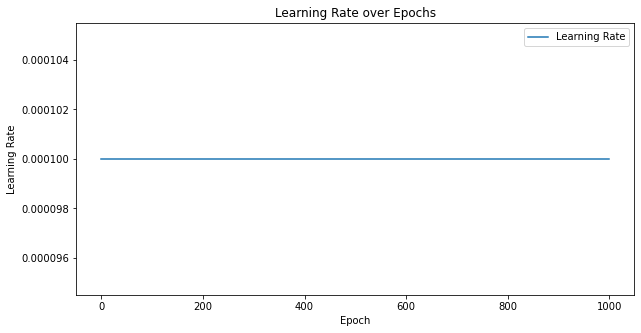

In [91]:
# Plot the learning rate
plot_learning_rate(lr_logger)

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model

def build_and_plot_model(layers, dropout_rate, input_shape, output_shape, learning_rate):
    model = Sequential()
    
    # Input layer
    model.add(Dense(layers[0], activation='relu', input_shape=(input_shape,)))
    model.add(Dropout(dropout_rate))
    
    # Hidden layers
    for layer_size in layers[1:]:
        model.add(Dense(layer_size, activation='relu'))
        model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(output_shape, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Plot the model
    plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)
    print("Model architecture saved as 'model_architecture.png'")

# Define parameters
layers = [256, 64, 32]        # Example: [256, 64, 32]
dropout_rate = 0.3            # Example: 0.3
input_shape = 200             # Example: number of input features
output_shape = 10             # Example: number of classes

# Build and plot the model
build_and_plot_model(layers, dropout_rate, input_shape, output_shape, learning_rate=0.001)

In [38]:
import os
os.getcwd()

'/home/localuser/Documents/mohit/new_classifier/NN_classifier'